<a href="https://colab.research.google.com/github/twishi03/liver/blob/master/DeepNuclei_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models==1.0.1
!pip install tensorflow===2.8.2
!pip install keras==2.8


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 64.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 

In [1]:
#For live loss function updates
!pip install livelossplot

In [2]:
%matplotlib inline

In [3]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [130]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [131]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/Deep Segment/image"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img=img/255.0
        img=img.astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/drive/MyDrive/Deep Segment/label"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask=mask/255.0
        mask=mask.astype(np.float32)
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing
train_masks = np.array(train_masks)


In [132]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)

x_val = preprocess_input(x_val)


In [133]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [134]:
# define model
BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, encoder_weights='imagenet' )
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())


94601216/94592056 [==============================] - 6s 0us/step
Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_331 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                     

In [136]:
# train model
history=model.fit(x_train, y_train,batch_size=32, epochs=1000, verbose=2,
                             validation_data=(x_val, y_val))


Epoch 1/1000
2/2 - 1s - loss: 1.2315 - iou_score: 0.1057 - val_loss: 1.5049 - val_iou_score: 0.1113 - 923ms/epoch - 461ms/step
Epoch 2/1000
2/2 - 1s - loss: 1.2260 - iou_score: 0.1320 - val_loss: 1.5738 - val_iou_score: 0.1066 - 823ms/epoch - 412ms/step
Epoch 3/1000
2/2 - 1s - loss: 1.2266 - iou_score: 0.1262 - val_loss: 3.9695 - val_iou_score: 0.0355 - 828ms/epoch - 414ms/step
Epoch 4/1000
2/2 - 1s - loss: 1.2261 - iou_score: 0.1181 - val_loss: 6.2359 - val_iou_score: 0.0283 - 854ms/epoch - 427ms/step
Epoch 5/1000
2/2 - 1s - loss: 1.2257 - iou_score: 0.1176 - val_loss: 9.1375 - val_iou_score: 0.0154 - 874ms/epoch - 437ms/step
Epoch 6/1000
2/2 - 1s - loss: 1.2243 - iou_score: 0.1420 - val_loss: 10.4403 - val_iou_score: 0.0082 - 864ms/epoch - 432ms/step
Epoch 7/1000
2/2 - 1s - loss: 1.2213 - iou_score: 0.1506 - val_loss: 4.6131 - val_iou_score: 0.0389 - 882ms/epoch - 441ms/step
Epoch 8/1000
2/2 - 1s - loss: 1.2196 - iou_score: 0.0890 - val_loss: 2.6187 - val_iou_score: 0.1232 - 864ms/ep

In [137]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
#from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
history = model.fit(x_train, y_train, batch_size=32, epochs=1000,
   verbose=2,
   validation_data=(x_val, y_val))

accuracy = model.evaluate(x_val, y_val)


Epoch 1/1000
2/2 - 1s - loss: 0.1402 - iou_score: 0.8857 - val_loss: 2.4087 - val_iou_score: 0.0108 - 979ms/epoch - 489ms/step
Epoch 2/1000
2/2 - 1s - loss: 0.1388 - iou_score: 0.8937 - val_loss: 2.4082 - val_iou_score: 0.0107 - 865ms/epoch - 432ms/step
Epoch 3/1000
2/2 - 1s - loss: 0.1379 - iou_score: 0.8845 - val_loss: 2.3975 - val_iou_score: 0.0110 - 833ms/epoch - 416ms/step
Epoch 4/1000
2/2 - 1s - loss: 0.1378 - iou_score: 0.8739 - val_loss: 2.4056 - val_iou_score: 0.0103 - 845ms/epoch - 422ms/step
Epoch 5/1000
2/2 - 1s - loss: 0.1396 - iou_score: 0.8932 - val_loss: 2.4342 - val_iou_score: 0.0089 - 847ms/epoch - 424ms/step
Epoch 6/1000
2/2 - 1s - loss: 0.1359 - iou_score: 0.8970 - val_loss: 2.4612 - val_iou_score: 0.0080 - 846ms/epoch - 423ms/step
Epoch 7/1000
2/2 - 1s - loss: 0.1375 - iou_score: 0.8983 - val_loss: 2.4635 - val_iou_score: 0.0083 - 845ms/epoch - 422ms/step
Epoch 8/1000
2/2 - 1s - loss: 0.1373 - iou_score: 0.8967 - val_loss: 2.4546 - val_iou_score: 0.0092 - 842ms/epo

In [138]:
model.save('/content/drive/MyDrive/Deep Segment.h5')

In [139]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Deep Segment.h5', compile=False)

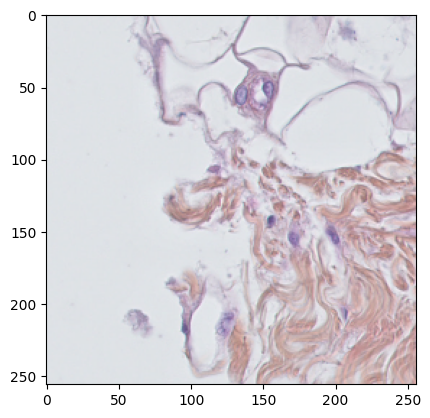

In [147]:

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/Deep Segment/test/10_4.png', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)





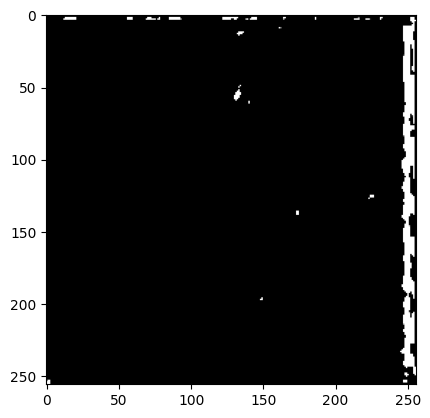

In [148]:
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
prediction_image=prediction_image/255.0
prediction_image=prediction_image.astype(np.float32)
plt.imshow(prediction_image, cmap='gray')
#plt.imsave('images/test_images/segmented.jpg', prediction_image, cmap='gray')
